In [104]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from tqdm import tqdm_notebook
from scipy.optimize import minimize, leastsq
from scipy.interpolate import interp1d
from astropy import units

COLOR = 'black'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula = np.load('/Users/arcticfox/parula_colors.npy')
parulacmap = np.load('/Users/arcticfox/parula_data.npy')

In [105]:
from matplotlib.colors import LinearSegmentedColormap

clist0 = np.array(['EA8F3C', 'EB6A41', '69469D', '241817'])
clist1 = np.array(['66C6C6', '2B8D9D', '19536C', '123958', '121422'])

def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

def make_cmap(clist, name='sequential'):
    rgb_tuples = []

    for c in clist:
        rgb_tuples.append(hex_to_rgb(c))

    cm = LinearSegmentedColormap.from_list(
            name, rgb_tuples, N=2048)
    return cm

cm = make_cmap(clist0, name='halloween')
cm1 = make_cmap(clist1, name='ocean')
parulacmap = LinearSegmentedColormap.from_list('sequential', parulacmap)

In [6]:
cmd = Table.read('cmd_conversion.txt', format='ascii')
cmd = cmd[cmd['Bp-Rp']!='...']

cmd_bprp = np.array([float(i) for i in cmd['Bp-Rp']])
cmd_mg = np.array([float(i) for i in cmd['M_G']])
cmd_mass = np.array([float(i) for i in cmd['Msun']])
cmd_teff = np.array([float(i) for i in cmd['Teff']])

In [7]:
flares = Table.read('all_flares_param_catalog_ruwe.tab', format='csv')
stars = Table.read('all_star_param_catalog_ruwe.tab', format='csv')

In [8]:
flares = flares[flares['prob']>0.75]
flares = flares[flares['amp']>0.005]

## Convert RUWE to physical distance

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


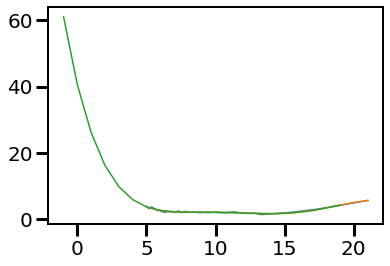

In [9]:
sigmaAL = Table.read('gaia_sigmaAL.txt', format='csv')
plt.plot(sigmaAL['Gmag'], sigmaAL['sigmaAL'])
poly = np.polyfit(sigmaAL['Gmag'].data, sigmaAL['sigmaAL'].data, deg=5)
interp_sigAL = np.poly1d(poly)
test = np.arange(-1,20,1)
plt.plot(sigmaAL['Gmag'], interp_sigAL(sigmaAL['Gmag']))
plt.plot(test, interp_sigAL(test))

deltheta = interp_sigAL(stars['M_G'].data.data) * np.sqrt(stars['RUWE'].data**2-1)

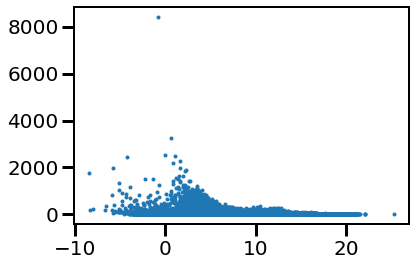

In [10]:
q = np.isnan(deltheta) == False
plt.plot(stars['M_G'][q], deltheta[q],'.')

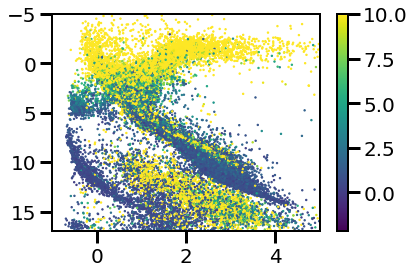

In [11]:
plt.scatter(stars['bp_rp'], stars['M_G'], 
             c=deltheta, s=2, zorder=0, vmax=10)
plt.ylim(17,-5)
plt.xlim(-1,5)
plt.colorbar()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


(-1.0, 5.0)

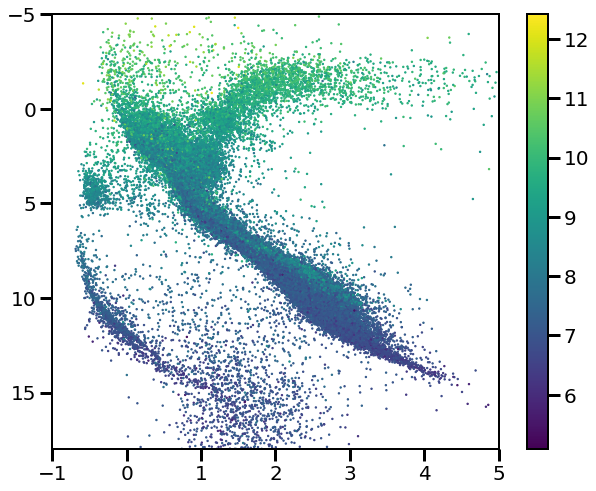

In [12]:
plt.figure(figsize=(10,8))
deltaa = (stars['TICv8_d']*units.pc).to(units.kpc) * deltheta
plt.scatter(stars['bp_rp'], stars['M_G'],
            c=np.log10(deltaa.to(units.AU).value), s=2)
plt.colorbar()
plt.ylim(18,-5)
plt.xlim(-1,5)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


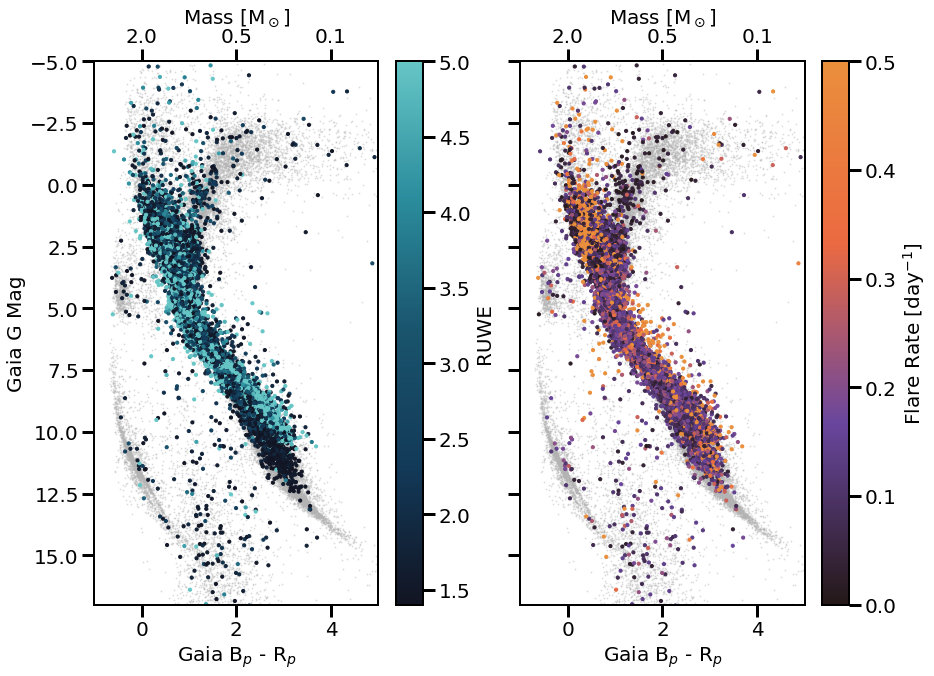

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,10), 
                               sharex=True, sharey=True)

ax3 = ax1.twiny()
ax4 = ax2.twiny()

absmag = stars['phot_g_mean_mag'] - 5*np.log10(stars['TICv8_d']/10)

ruwe_cutoff = 1.4
fig.set_facecolor('w')
ax1.plot(stars['bp_rp'], absmag, '.', 
         c='#b3b3b3', ms=2, alpha=0.3, zorder=0)
im = ax1.scatter(stars['bp_rp'][stars['RUWE']>=ruwe_cutoff], 
                absmag[stars['RUWE']>=ruwe_cutoff], 
                c=stars['RUWE'][stars['RUWE']>=ruwe_cutoff], s=10, 
                vmin=ruwe_cutoff, vmax=5, zorder=3,
                cmap=cm1.reversed())
fig.colorbar(im, ax=ax1, label='RUWE')
#ax1.colorbar(label='RUWE')

inds = np.where((stars['teff'] > 6000) & 
                (stars['lum']>3) & 
                (stars['N_flares_per_day']>2) &
                (stars['RUWE'] < ruwe_cutoff))[0]
good_inds = np.delete(np.arange(0,len(stars),1,dtype=int), inds)
ax2.plot(stars['bp_rp'][good_inds], 
         absmag[good_inds], '.',
         c='#b3b3b3', ms=2, alpha=0.3, zorder=0)

good_inds = stars['RUWE'] > ruwe_cutoff
im = ax2.scatter(stars['bp_rp'][good_inds], 
                 absmag[good_inds], 
                 c=stars['N_flares_per_day'][good_inds], s=10, 
                 vmin=0, vmax=0.5,
                 cmap=cm.reversed(), zorder=3)
fig.colorbar(im, ax=ax2, label='Flare Rate [day$^{-1}$]')
#ax2.colorbar(label='Flare Rate')

xticks = [0,2,4]
upxticks = np.array([cmd_mass[cmd_bprp>=0][0], 
                     cmd_mass[cmd_bprp>=2][0], 
                     cmd_mass[cmd_bprp>=4][0]])
ax1.set_xlim(-1, 5)
ax2.set_xlim(-1, 5)
ax3.set_xlim(-1, 5)
ax4.set_xlim(-1, 5)
ax1.set_xticks(xticks)
ax3.set_xticks(xticks)
ax3.set_xlabel('Mass [M$_\odot$]')
ax3.set_xticklabels(np.round(upxticks,1))

ax2.set_xticks(xticks)
ax4.set_xticks(xticks)
ax4.set_xlabel('Mass [M$_\odot$]')
ax4.set_xticklabels(np.round(upxticks,1))
#plt.yscale('log')
plt.ylim(17,-5)
ax1.set_xlabel('Gaia B$_p$ - R$_p$')
ax2.set_xlabel('Gaia B$_p$ - R$_p$')
ax1.set_ylabel('Gaia G Mag')
ax1.set_rasterized(True)
ax2.set_rasterized(True)
#plt.savefig('ruwe_hr.pdf', dpi=250, rasterize=True, bbox_inches='tight')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


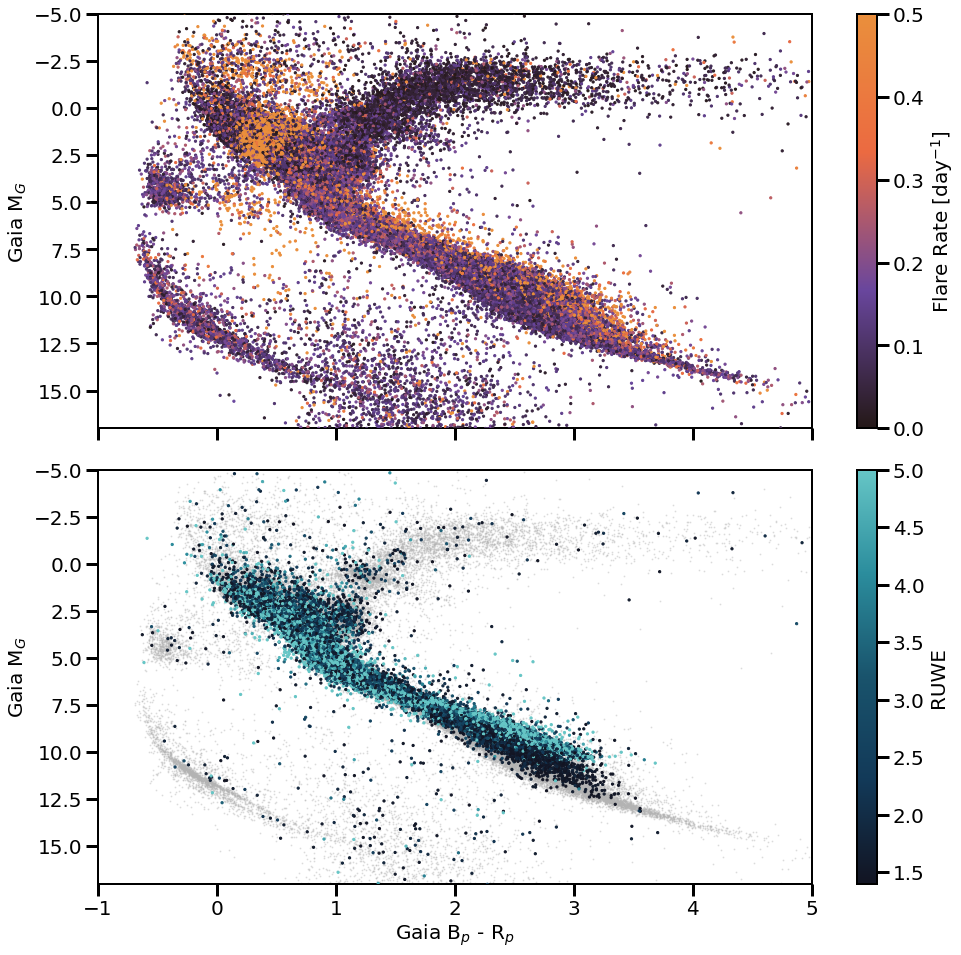

In [14]:
fig, (ax2, ax1) = plt.subplots(nrows=2, figsize=(16,16), 
                               sharex=True, sharey=True)

absmag = stars['phot_g_mean_mag'] - 5*np.log10(stars['TICv8_d']/10)

ruwe_cutoff = 1.4
fig.set_facecolor('w')
ax1.plot(stars['bp_rp'], absmag, '.', 
         c='#b3b3b3', ms=2, alpha=0.3, zorder=0)
im = ax1.scatter(stars['bp_rp'][stars['RUWE']>=ruwe_cutoff], 
                 absmag[stars['RUWE']>=ruwe_cutoff], 
                 c=stars['RUWE'][stars['RUWE']>=ruwe_cutoff], 
                 s=5, 
                 vmin=ruwe_cutoff, vmax=5, zorder=3,
                 cmap=cm1.reversed())
fig.colorbar(im, ax=ax1, label='RUWE')
#ax1.colorbar(label='RUWE')

inds = np.where((stars['teff'] > 6000) & 
                (stars['lum']>3) & 
                (stars['N_flares_per_day']>2) &
                (stars['RUWE'] < ruwe_cutoff))[0]
good_inds = np.delete(np.arange(0,len(stars),1,dtype=int), inds)
#ax2.plot(stars['bp_rp'][good_inds], 
#         absmag[good_inds], '.',
#         c='#b3b3b3', ms=2, alpha=0.3, zorder=0)

good_inds = stars['RUWE'] > ruwe_cutoff
im = ax2.scatter(stars['bp_rp'],#[good_inds], 
                 absmag,#[good_inds], 
                 c=stars['N_flares_per_day'],#[good_inds], 
                 s=5, 
                 vmin=0, vmax=0.5,
                 cmap=cm.reversed(), zorder=3)
fig.colorbar(im, ax=ax2, label='Flare Rate [day$^{-1}$]')
#ax2.colorbar(label='Flare Rate')

xticks = [-1,0,1,2,3,4,5]
upxticks = np.array([cmd_mass[cmd_bprp>=0][0], 
                     cmd_mass[cmd_bprp>=2][0], 
                     cmd_mass[cmd_bprp>=4][0]])
ax1.set_xlim(-1, 5)
ax2.set_xlim(-1, 5)
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)
#plt.yscale('log')
plt.ylim(17,-5)

"""
ax3 = ax1.twiny()
ax4 = ax2.twiny()
ax3.set_xlim(-1, 5)
ax4.set_xlim(-1, 5)
ax3.set_xticks(xticks)
ax3.set_xlabel('Mass [M$_\odot$]')
ax3.set_xticklabels(np.round(upxticks,1))
ax4.set_xticks(xticks)
ax4.set_xlabel('Mass [M$_\odot$]')
ax4.set_xticklabels(np.round(upxticks,1))
"""

ax1.set_xlabel('Gaia B$_p$ - R$_p$')
ax1.set_ylabel('Gaia M$_G$')
ax2.set_ylabel('Gaia M$_G$')
plt.subplots_adjust(hspace=0.1)
ax1.set_rasterized(True)
ax2.set_rasterized(True)
#plt.savefig('ruwe_hr.pdf', dpi=250, rasterize=True, bbox_inches='tight')

In [15]:
stars['M_G'] = absmag

In [16]:
def linear_fit(args, x, y, num):
    m, b = args
    fit = m*x+b#b * x**m 
    return np.nansum((y-fit)**2/num**2)

def linear(args, x):
    m, b = args
    fit = m*x+b#b * x**m
    return fit

def power_law(args, x):
    m, b = args
    fit = b * x**m
    return fit

def linear_resid(args, x, y, num):
    m, b = args
    fit = m*x+b#b * x**m 
    return (y-fit)/num

def power_law_resid(args, x, y, num):
    m, b = args
    fit = b * x**m 
    return (y-fit)/num

In [17]:
def amp_slope_fit(data, bins, i=0, j=-1):
    
    n, _ = np.histogram(data['amp']*100, bins=bins)
    y, binedges, _ = plt.hist(data['amp']*100, bins=bins,
                          weights=np.full(len(data['amp']),
                                          1.0/np.nansum(data['weights'])),
                          alpha=0.4)
    plt.close()
    x = binedges[1:] + 0.0
    logx = np.log10(x)
    logn = np.log10(n)
    q = logn > 0

    plt.plot(logx[i:j], np.log10(n[i:j]), '.', c='k')
    plt.plot(logx[i:j], linear([-2.5, 7], logx[i:j]), '--', c='w', linewidth=3)

    results = minimize(linear_fit, x0=[-2.5, 7],
                       args=(logx[q][i:j-1]-np.diff(logx[q][i:j])/2., 
                             logn[q][i:j-1], np.sqrt(logn[q][i:j-1]) ), 
                       bounds=( (-10.0, 10.0), (-100, 100)),
                       method='L-BFGS-B', tol=1e-8)
    
    results.x[1] = 10**results.x[1]

    results2 = leastsq(power_law_resid, results.x,
                       args=(x[q][i:j-1]-np.diff(x[q][i:j])/2., 
                             n[q][i:j-1], 
                             np.sqrt(n[q][i:j-1]) ),
                       full_output=True)

    fit_params = results2[0]
    
    slope_err = np.sqrt(results2[1][0][0])

    model = linear([fit_params[0], np.log10(fit_params[1])], logx)
    plt.title('{} $\pm$ {}'.format(np.round(fit_params[0],2),
                                   np.round(slope_err,2)))
    plt.plot(logx, model, c='r')
    plt.show()

    #print(fit_params[0], slope_err)

    return fit_params[0], slope_err

In [18]:
starbins = [0.05, 0.5, 0.8, 1.7, 3.0]

(15.0, -5.0)

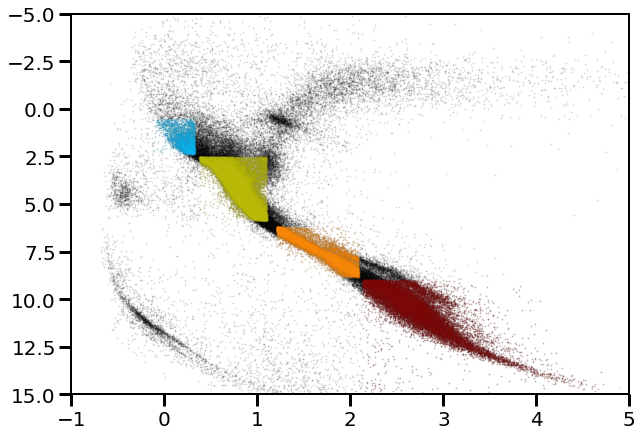

In [19]:
plt.figure(figsize=(10,7))

plt.xlim(-1,5)

plt.plot(stars['bp_rp'], absmag,'k.', alpha=0.1, ms=2)
colors = ['maroon', 'darkorange', 'y', 'deepskyblue']
subbprp = np.array([])
subg = np.array([])

for i in range(len(starbins)-1):
    inds = np.where((cmd_mass>=starbins[i]) & (cmd_mass<starbins[i+1]))[0]
    #plt.plot(cmd_bprp[inds], cmd_mg[inds], '*', c=colors[i], ms=10)
    dat = stars[(stars['bp_rp']>= cmd_bprp[inds][0]) &
                 (stars['bp_rp']<=  cmd_bprp[inds][-1]) &
                 (stars['M_G']>= cmd_mg[inds][0]) &
                 (stars['M_G']<=  cmd_mg[inds][-1]) &
                (stars['M_G'] <= 15)]
    plt.plot(dat['bp_rp'], dat['M_G'], '.', alpha=0.1, ms=2, c=colors[i])
    subbprp = np.append(subbprp, dat['bp_rp'].data)
    subg = np.append(subg, dat['M_G'].data)
    
plt.ylim(15,-5)

(20.0, 0.0)

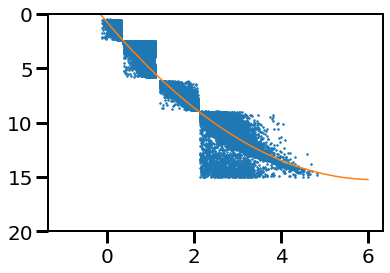

In [20]:
plt.plot(subbprp, subg, '.', ms=3)
fit = np.polyfit(subbprp, subg, deg=2)
model = np.poly1d(fit)
x = np.linspace(-1,6,100)
plt.plot(x, model(x))
plt.ylim(20,0)

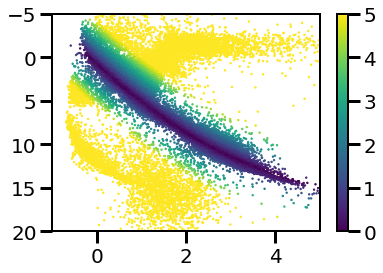

In [21]:
plt.scatter(stars['bp_rp'], absmag,
            c=np.abs(absmag - model(stars['bp_rp'])),
            s=2, vmin=0, vmax=5)
plt.ylim(20,-5)
plt.xlim(-1,5)
plt.colorbar()
ms_dist = np.abs(flares['M_G'] - model(flares['bp_rp']))

0.05 0.5 181207
0.05 0.5 29056


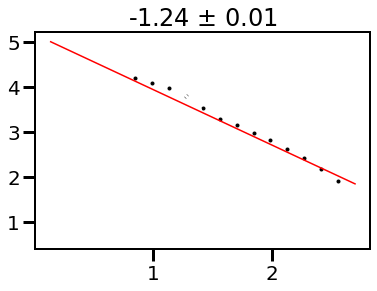

0.5 0.8 70032
0.5 0.8 17898


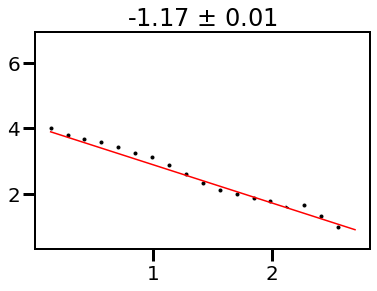

0.8 1.7 449648
0.8 1.7 79927


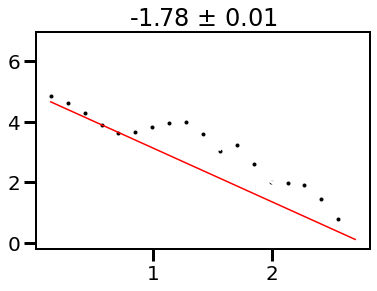

1.7 3.0 210665
1.7 3.0 3780


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


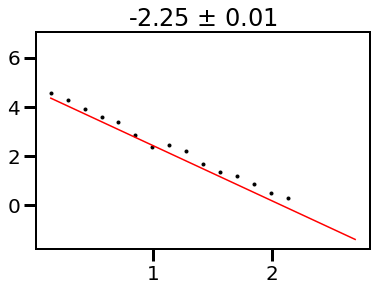

In [75]:
slopes = np.zeros(len(starbins)-1)
errs = np.zeros(len(starbins)-1)
binsizes = np.zeros(len(starbins)-1)

bins = np.logspace(np.log10(1), np.log10(500),20)

for i in range(len(starbins)-1):
    
    inds = np.where((cmd_mass>=starbins[i]) & (cmd_mass<starbins[i+1]))[0]
    dat = flares[(flares['bp_rp']>= cmd_bprp[inds][0]) &
                 (flares['bp_rp']<  cmd_bprp[inds][-1]) &
                 (ms_dist < 2)]
    print(starbins[i], starbins[i+1], len(dat))
    
    s = stars[(stars['bp_rp']>= cmd_bprp[inds][0]) &
              (stars['bp_rp']<  cmd_bprp[inds][-1]) &
              (np.abs(absmag - model(stars['bp_rp'])) < 2)]
    print(starbins[i], starbins[i+1], len(s))

    if i == 0:
        slope, err = amp_slope_fit(dat, 
                                   bins=bins, i=5)
    else:
        slope, err = amp_slope_fit(dat, 
                                   bins=bins)
    slopes[i] = slope
    errs[i] = err
    binsizes[i] = len(dat)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


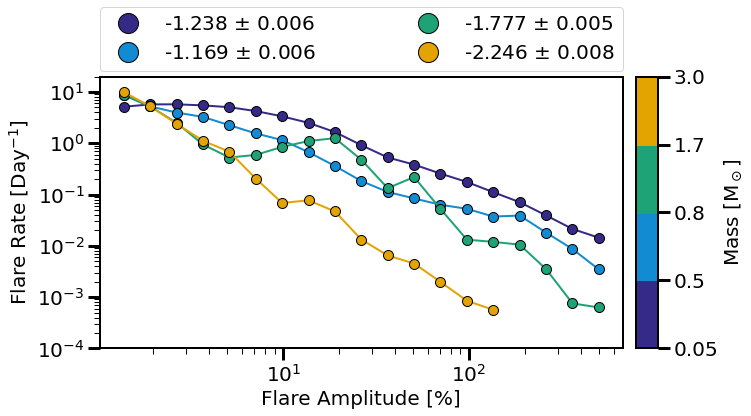

In [23]:
fig, ax = plt.subplots(figsize=(10,10),sharex=True, sharey=True)   

#bins = np.logspace(np.log10(1), np.log10(500),20)
histplots = []
for i in range(len(starbins)-1):
    inds = np.where((cmd_mass>=starbins[i]) & (cmd_mass<starbins[i+1]))[0]
    dat = flares[(flares['bp_rp']>= cmd_bprp[inds][0]) &
                 (flares['bp_rp']<  cmd_bprp[inds][-1]) &
                 (ms_dist < 2) ]
    
    n = ax.hist(dat['amp']*100, bins=bins, color='k',
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.4, label='{0} $\pm$ {1}'.format(np.round(slopes[i],2),
                                                         np.round(errs[i], 2)))
    histplots.append(n)
    
plt.close()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5),
                               gridspec_kw={'width_ratios':[12,0.5]}) 
fig.set_facecolor('w')
cinds = parula[np.linspace(0, 210, len(histplots), dtype=int)]
cinds[-2] = '#1da376'#'#53BC8E'
cinds[-1] = '#e3a300'

for i in range(len(histplots)):
    q = histplots[i][0] > 0
    ax1.plot(histplots[i][1][1:][q], histplots[i][0][q], c=cinds[i], lw=2)
    ax1.plot(histplots[i][1][1:][q], histplots[i][0][q], 'o', c=cinds[i],
             ms=10, markeredgecolor='k', lw=0.5,
             label='{} $\pm$ {}'.format(np.round(slopes[i],3),
                                        np.round(errs[i], 3)))
    
ax1.set_yscale('log')
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

ax1.set_xlabel('Flare Amplitude [%]')
ax1.set_ylabel('Flare Rate [Day$^{-1}$]')
ax1.set_xscale('log')
ax1.set_ylim(10**-4, 20)

ax2.set_xticks([])

ax2.set_ylim(0,4)
ax2.set_xlim(0,1)

for i in range(len(cinds)):
    ax2.plot(0.5, i+0.5, 's', ms=67,
             c=cinds[i])
ax2.yaxis.tick_right()
ax2.set_yticklabels(starbins)
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Mass [M$_\odot$]')

plt.subplots_adjust(wspace=0.05)

ax1.set_rasterized(True)
ax2.set_rasterized(True)

#plt.savefig('amp_rates.png', rasterize=True, bbox_inches='tight', dpi=300)

## By RUWE Values

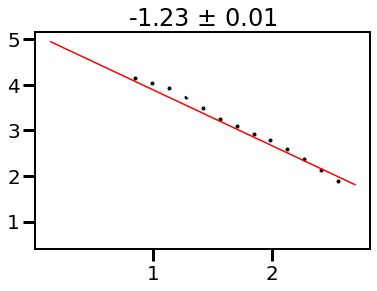

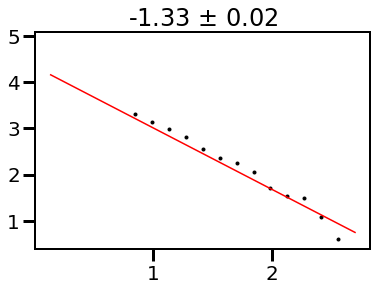

34694


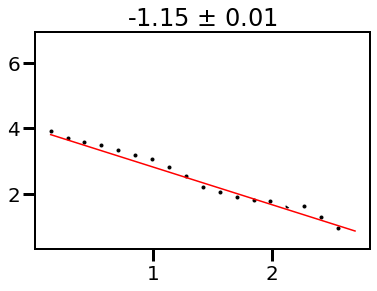

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


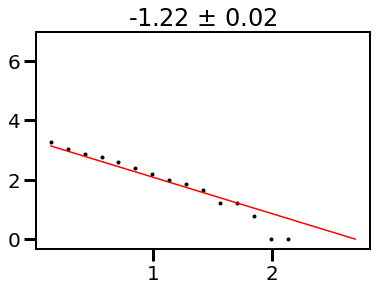

12855


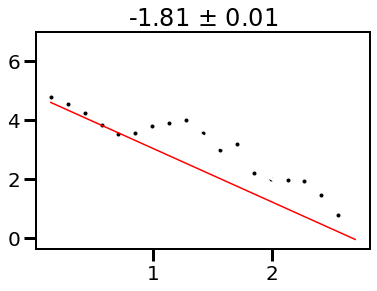

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


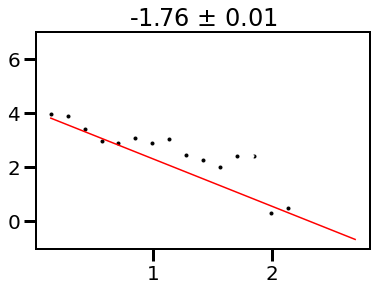

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


74869


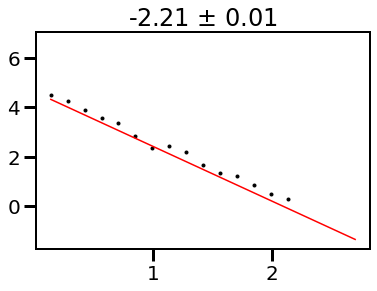

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


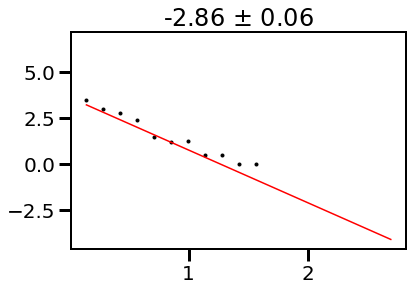

22039


In [24]:
high_ruwe_slopes = np.zeros(len(starbins)-1)
high_ruwe_errs = np.zeros(len(starbins)-1)
low_ruwe_slopes = np.zeros(len(starbins)-1)
low_ruwe_errs = np.zeros(len(starbins)-1)

for i in range(len(starbins)-1):
    
    inds = np.where((cmd_mass>=starbins[i]) & (cmd_mass<starbins[i+1]))[0]
    dat = flares[(flares['bp_rp']>= cmd_bprp[inds][0]) &
                 (flares['bp_rp']<  cmd_bprp[inds][-1]) &
                 (ms_dist < 2) &
                 (flares['RUWE'] < 1.4)]
    if i == 0:
        slope, err = amp_slope_fit(dat, 
                                   bins=bins, i=5)
    else:
        slope, err = amp_slope_fit(dat, bins=bins)
    low_ruwe_slopes[i] = slope
    low_ruwe_errs[i] = err
    
    
    dat = flares[(flares['bp_rp']>= cmd_bprp[inds][0]) &
                 (flares['bp_rp']<  cmd_bprp[inds][-1]) &
                 (ms_dist < 2) &
                 (flares['RUWE'] >= 1.4)]
    if i == 0:
        slope, err = amp_slope_fit(dat, 
                                   bins=bins, i=5)
    elif i > 4:
        slope, err = amp_slope_fit(dat, bins=bins)
    else:
        slope, err = amp_slope_fit(dat, bins=bins, j=-4)
    high_ruwe_slopes[i] = slope
    high_ruwe_errs[i] = err
    
    print(len(dat))

In [25]:
starbins

[0.05, 0.5, 0.8, 1.7, 3.0]

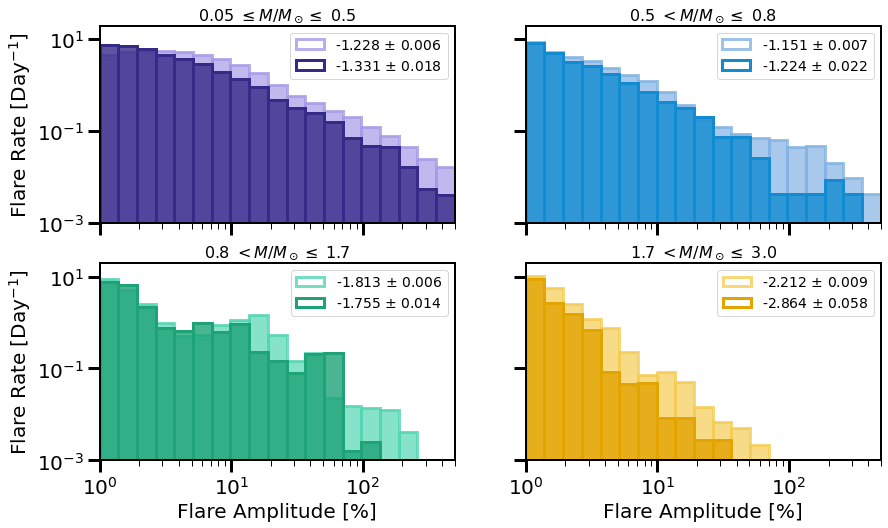

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(14,8),
                                             sharex=True, sharey=True)   
fig.set_facecolor('w')
axes = [ax1, ax2, ax3, ax4]

oppo = ['#a79ae6', '#84b3e3', '#53d6b3', '#f5cd54']

high_ruwe_n = []
low_ruwe_n = []
#bins = np.logspace(np.log10(1), np.log10(500),20)

for i in range(len(starbins)-1):
    inds = np.where((cmd_mass>=starbins[i]) & (cmd_mass<starbins[i+1]))[0]
    dat = flares[(flares['bp_rp']>= cmd_bprp[inds][0]) &
                 (flares['bp_rp']<  cmd_bprp[inds][-1]) &
                 (ms_dist < 2) & (flares['RUWE']<1.4)]
    
    n = axes[i].hist(dat['amp']*100, bins=bins, color=oppo[i],#'#c4c2c1',#oppo[i],
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.7)
    axes[i].hist(dat['amp']*100, bins=bins, color=oppo[i],#'#c4c2c1',#oppo[i],
                 edgecolor=oppo[i], linewidth=3,fill=None,
                 weights=np.full(len(dat['amp']), 
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.8,
                 label='{0} $\pm$ {1}'.format(np.round(low_ruwe_slopes[i],3),
                                                         np.round(low_ruwe_errs[i], 3)))
                           
    low_ruwe_n.append(n)
    
    dat = flares[(flares['bp_rp']>= cmd_bprp[inds][0]) &
                 (flares['bp_rp']<  cmd_bprp[inds][-1]) &
                 (ms_dist < 2) & (flares['RUWE']>=1.4)]
    
    n = axes[i].hist(dat['amp']*100, bins=bins, color=cinds[i],
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.8)
    
    high_ruwe_n.append(n)
    
    axes[i].hist(dat['amp']*100, bins=bins, color=cinds[i],
                 edgecolor=cinds[i], linewidth=3,fill=None,
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 label='{0} $\pm$ {1}'.format(np.round(high_ruwe_slopes[i],3),
                                                         np.round(high_ruwe_errs[i], 3)))
    axes[i].legend(ncol=1, fontsize=14)
    
    if i == 0:
        axes[i].set_title('{} $\leq M/M_\odot \leq$ {}'.format(starbins[i], starbins[i+1]),
                          fontsize=16)
    else:
        axes[i].set_title('{} $< M/M_\odot \leq$ {}'.format(starbins[i], starbins[i+1]),
                          fontsize=16)
    
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,500)
plt.ylim(10**-3, 20)

ax1.set_ylabel('Flare Rate [Day$^{-1}$]')
ax3.set_ylabel('Flare Rate [Day$^{-1}$]')
ax3.set_xlabel('Flare Amplitude [%]')
ax4.set_xlabel('Flare Amplitude [%]')

for ax in axes:
    ax.set_rasterized(True)

#plt.savefig('by_ruwe.pdf', rasterize=True, bbox_inches='tight', dpi=300)

In [27]:
high_ruwe_slopes

array([-1.33054629, -1.22434946, -1.75527605, -2.86363987])

In [28]:
low_ruwe_slopes

array([-1.22762618, -1.15124674, -1.81298183, -2.21174732])

In [29]:
for i in range(len(high_ruwe_slopes)):
    diff = np.abs(low_ruwe_slopes[i] - high_ruwe_slopes[i])
    print(diff/high_ruwe_errs[i])

5.689013598080882
3.3971378690937812
4.04975025614615
11.242831704497393


## Comparison

In [46]:
lit = Table.read('lit_flares.csv', format='csv')
avgmass = np.zeros(len(lit))
massrange = np.zeros(len(lit))

for i in range(len(lit)):
    ran = [int(i) for i in lit['teff'][i].split('-')]
    mask = (cmd_teff>=ran[0]) & (cmd_teff<=ran[1])
    avgmass[i] = (cmd_mass[mask][-1]+cmd_mass[mask][0]) / 2.0

    massrange[i] = np.nanmedian([cmd_mass[mask][0]-avgmass[i], avgmass[i]-cmd_mass[mask][-1]])
lit.add_column(Column(avgmass, 'avg_mass'))
lit.add_column(Column(massrange, 'mass_range'))
#lit.add_column

//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


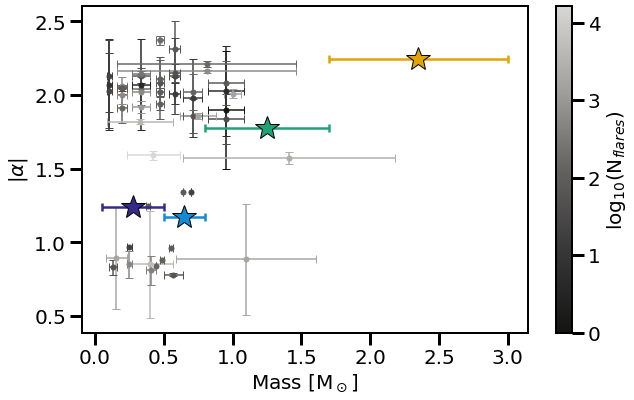

In [137]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor('w')
logn = np.log10(lit['nflares']) +0.0

import matplotlib
import matplotlib.cm as cm


glist = ['#141413','#383737', '#636261', '#a3a1a0', '#d9d7d6']
mygray = make_cmap(glist, name='mygray')
norm = matplotlib.colors.Normalize(vmin=min(logn), vmax=max(logn), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=mygray)
scattercolors = np.array([(mapper.to_rgba(v)) for v in logn])

#for x, y, e, color in zip(time, signal, error, time_color):
#    plt.plot(x, y, 'o', color=color)
#    plt.errorbar(x, y, e, lw=1, capsize=3, color=color)

for i in range(len(lit)):
    plt.errorbar(lit['avg_mass'][i],
                 lit['slope'][i],
                 xerr=lit['mass_range'][i],
                 yerr=lit['error'][i], capsize=4,
                 marker='o', linestyle='', color=scattercolors[i], ms=5)
    #plt.plot(lit['avg_mass'][i], lit['slope'][i], 
    #         c=scattercolors[i], zorder=100)
    
for i in range(len(slopes)):
    avg = (starbins[i]+starbins[i+1])/2
    merr = np.nanmedian([avg-starbins[i], starbins[i+1]-avg])
    (_, caps, _) = plt.errorbar(avg,
                                 np.abs(slopes[i]),
                                 xerr=merr,
                                 yerr=errs[i],
                                 marker='*', linestyle='', color=cinds[i], ms=25,
                                 zorder=200, capsize=4, markeredgecolor='k', 
                                 lw=2.5)
    for cap in caps:
        cap.set_markeredgewidth(2.5)

sc = plt.scatter(lit['avg_mass'],lit['slope'],s=0,c=logn, cmap=mygray)
clb = plt.colorbar(sc, label=r'log$_{10}$(N$_{flares}$)')
plt.ylabel(r'|$\alpha$|')
plt.xlabel(r'Mass [M$_\odot$]')
plt.savefig('comparison.pdf', dpi=300, rasterize=True, bbox_inches='tight')

In [76]:
np.log10(binsizes)

array([5.25817497, 4.84529653, 5.65287267, 5.32359239])

In [70]:
slopes

array([-1.23810685, -1.16926739, -1.77746546, -2.24576373])